Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 Verifying dataset structure...
✅ Dataset structure verified successfully!

📂 Loading dataset...

Loading 826 images from /content/drive/MyDrive/MRI/Training/glioma_tumor...


glioma_tumor: 100%|██████████| 826/826 [00:08<00:00, 101.09it/s]



Loading 395 images from /content/drive/MyDrive/MRI/Training/no_tumor...


no_tumor: 100%|██████████| 395/395 [04:53<00:00,  1.35it/s]



Loading 822 images from /content/drive/MyDrive/MRI/Training/meningioma_tumor...


meningioma_tumor: 100%|██████████| 822/822 [10:06<00:00,  1.36it/s]



Loading 827 images from /content/drive/MyDrive/MRI/Training/pituitary_tumor...


pituitary_tumor: 100%|██████████| 827/827 [10:06<00:00,  1.36it/s]



Loading 100 images from /content/drive/MyDrive/MRI/Testing/glioma_tumor...


glioma_tumor: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]



Loading 105 images from /content/drive/MyDrive/MRI/Testing/no_tumor...


no_tumor: 100%|██████████| 105/105 [01:08<00:00,  1.54it/s]



Loading 115 images from /content/drive/MyDrive/MRI/Testing/meningioma_tumor...


meningioma_tumor: 100%|██████████| 115/115 [01:25<00:00,  1.35it/s]



Loading 74 images from /content/drive/MyDrive/MRI/Testing/pituitary_tumor...


pituitary_tumor: 100%|██████████| 74/74 [00:56<00:00,  1.30it/s]



✅ Successfully loaded 3264 images


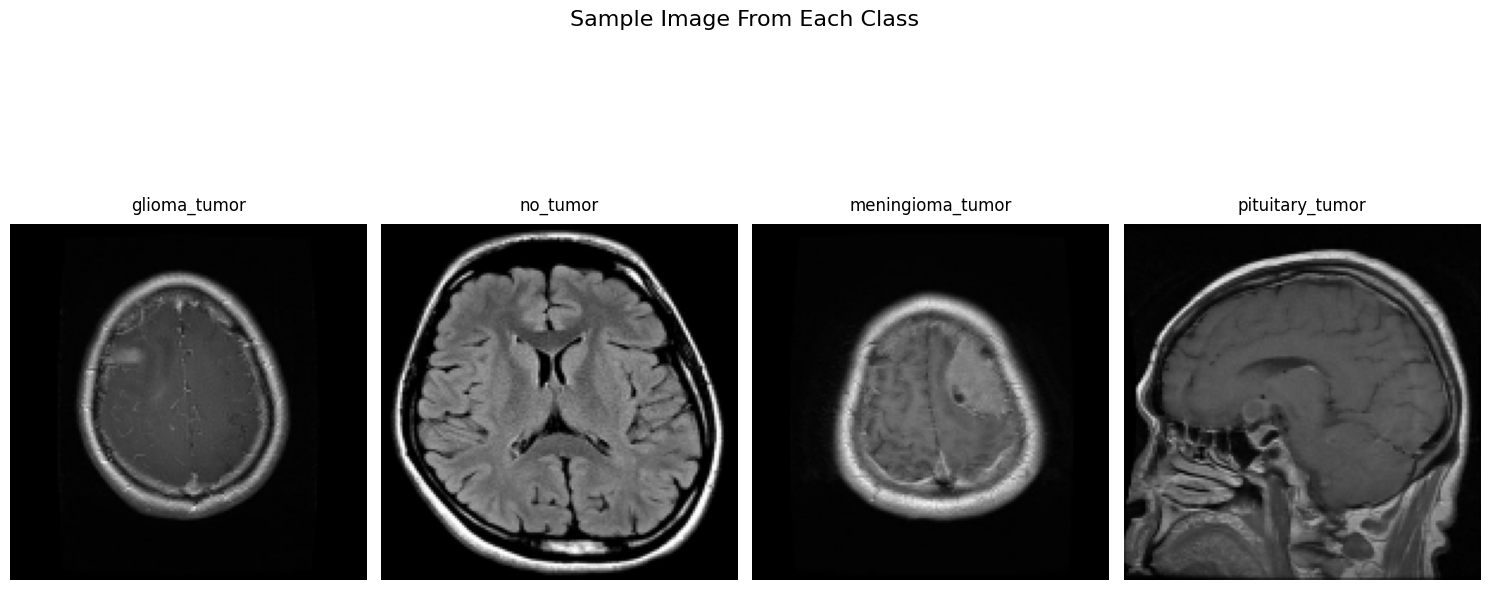


Balancing dataset with SMOTE...

Class distribution:
Original: Counter({np.int64(1): 841, np.int64(0): 833, np.int64(3): 814, np.int64(2): 449})
After SMOTE: Counter({np.int64(0): 841, np.int64(2): 841, np.int64(3): 841, np.int64(1): 841})

Building Vision Transformer model...

Training model...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.2677 - loss: 2.7680
Epoch 1: val_accuracy improved from -inf to 0.17507, saving model to /tmp/best_model.weights.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 109s 920ms/step - accuracy: 0.2678 - loss: 2.7557 - val_accuracy: 0.1751 - val_loss: 1.3644 - learning_rate: 0.0010
Epoch 2/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3314 - loss: 1.4300
Epoch 2: val_accuracy improved from 0.17507 to 0.17804, saving model to /tmp/best_model.weights.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.3326 - loss: 1.4281 - val_accuracy: 0.1780 - val_loss: 1.9768 - learning_rate: 0.0010
Epoch 3/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

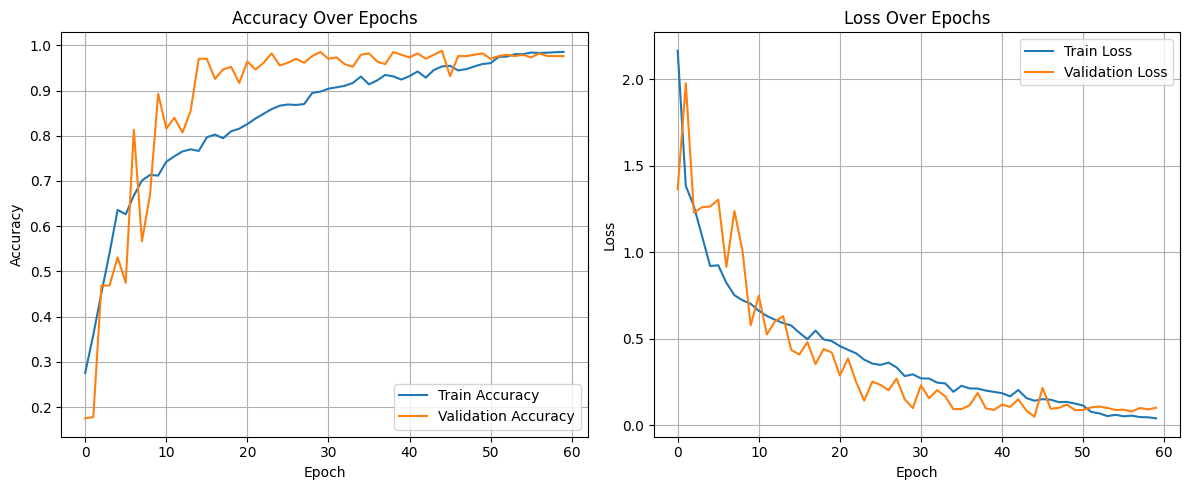

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step


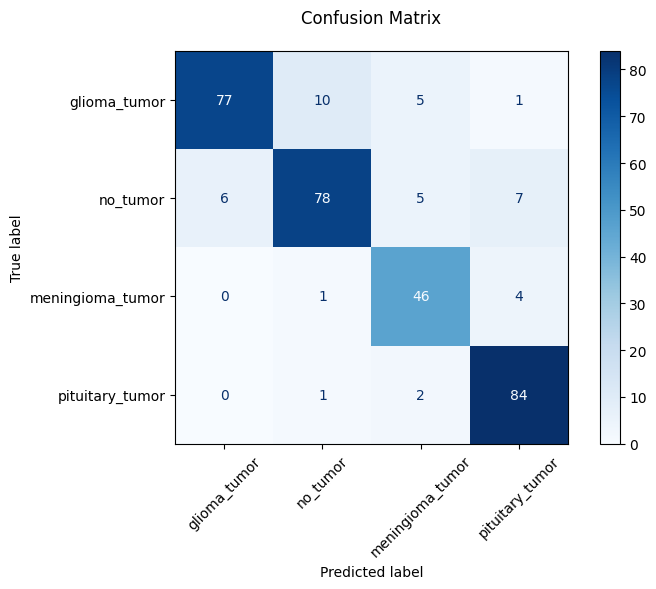


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.83      0.88        93
        no_tumor       0.87      0.81      0.84        96
meningioma_tumor       0.79      0.90      0.84        51
 pituitary_tumor       0.88      0.97      0.92        87

        accuracy                           0.87       327
       macro avg       0.87      0.88      0.87       327
    weighted avg       0.87      0.87      0.87       327


🚀 Ready for predictions! Upload an MRI image below:


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from warnings import filterwarnings
from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

# Filter warnings
filterwarnings('ignore')

# Mount Google Drive
drive.mount("/content/drive")

# Configuration Section
class Config:
    """Configuration parameters for the tumor classification system."""
    
    # Dataset configuration
    DATA_ROOT = '/content/drive/MyDrive/MRI'
    TRAIN_DIR = 'Training'
    TEST_DIR = 'Testing'
    CLASSES = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
    IMAGE_SIZE = 150

    # Model configuration
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001

    # ViT specific parameters
    PATCH_SIZE = 16
    PROJECTION_DIM = 48
    NUM_HEADS = 8
    TRANSFORMER_LAYERS = 10
    MLP_UNITS = [1024, 512]
    DROPOUT_RATE = 0.1


# Dataset Verification
def verify_dataset_structure():
    """Verify the dataset structure and contents."""
    print("Verifying dataset structure...")

    # Check root directory
    if not os.path.exists(Config.DATA_ROOT):
        raise FileNotFoundError(f"Root directory not found: {Config.DATA_ROOT}")

    # Check train and test directories
    train_path = os.path.join(Config.DATA_ROOT, Config.TRAIN_DIR)
    test_path = os.path.join(Config.DATA_ROOT, Config.TEST_DIR)

    missing = []
    if not os.path.exists(train_path):
        missing.append(train_path)
    if not os.path.exists(test_path):
        missing.append(test_path)

    if missing:
        print("\nMissing directories:")
        for path in missing:
            print(f"- {path}")
        print("\nPlease ensure your Google Drive contains:")
        print(f"- {Config.DATA_ROOT}/{Config.TRAIN_DIR}/")
        print(f"- {Config.DATA_ROOT}/{Config.TEST_DIR}/")
        raise FileNotFoundError("Required directories missing")

    # Check class subdirectories
    missing_classes = []
    empty_classes = []

    for split in [Config.TRAIN_DIR, Config.TEST_DIR]:
        for class_name in Config.CLASSES:
            class_path = os.path.join(Config.DATA_ROOT, split, class_name)

            if not os.path.exists(class_path):
                missing_classes.append(class_path)
            elif len(os.listdir(class_path)) == 0:
                empty_classes.append(class_path)

    if missing_classes or empty_classes:
        print("\nDataset issues found:")
        for path in missing_classes:
            print(f"- Missing directory: {path}")
        for path in empty_classes:
            print(f"- Empty directory: {path}")

        print("\nRequired structure:")
        print(f"{Config.DATA_ROOT}/")
        print(f"├── {Config.TRAIN_DIR}/")
        print("│   ├── glioma_tumor/ [with images]")
        print("│   ├── no_tumor/ [with images]")
        print("│   ├── meningioma_tumor/ [with images]")
        print("│   └── pituitary_tumor/ [with images]")
        print(f"└── {Config.TEST_DIR}/")
        print("    ├── glioma_tumor/ [with images]")
        print("    ├── no_tumor/ [with images]")
        print("    ├── meningioma_tumor/ [with images]")
        print("    └── pituitary_tumor/ [with images]")

        if missing_classes:
            raise FileNotFoundError("Missing class directories")
        if empty_classes:
            raise ValueError("Empty class directories found")

    print("Dataset structure verified successfully.")


# Data Loading
def load_dataset():
    """Load and combine training and testing datasets."""
    print("\nLoading dataset...")

    X, y = [], []
    total_images = 0

    for split in [Config.TRAIN_DIR, Config.TEST_DIR]:
        split_path = os.path.join(Config.DATA_ROOT, split)

        for class_name in Config.CLASSES:
            class_path = os.path.join(split_path, class_name)
            image_files = os.listdir(class_path)

            if not image_files:
                print(f"Warning: No images found in {class_path}")
                continue

            print(f"\nLoading {len(image_files)} images from {class_path}...")

            for filename in tqdm(image_files, desc=class_name):
                img_path = os.path.join(class_path, filename)

                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {filename}")
                        continue

                    img = cv2.resize(img, (Config.IMAGE_SIZE, Config.IMAGE_SIZE))
                    img = img / 255.0  # Normalize
                    X.append(img)
                    y.append(class_name)
                    total_images += 1

                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")

    if total_images == 0:
        raise ValueError("No images were loaded. Please check your dataset.")

    print(f"\nSuccessfully loaded {total_images} images")
    return np.array(X), np.array(y)


# Data Visualization
def plot_sample_images(X, y, classes):
    """Display sample images from each class."""
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(classes):
        # Find the first occurrence of this class
        idx = np.where(y == class_name)[0][0]

        plt.subplot(1, len(classes), i+1)
        plt.imshow(X[idx])
        plt.title(class_name, pad=10)
        plt.axis('off')

    plt.suptitle('Sample Image From Each Class', fontsize=16, y=0.75)
    plt.tight_layout()
    plt.show()


# Model Architecture
def create_vit_model():
    """Create Vision Transformer model for tumor classification."""
    inputs = layers.Input(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3))

    # Create patches
    patches = Patches(Config.PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(
        num_patches=(Config.IMAGE_SIZE // Config.PATCH_SIZE) ** 2,
        projection_dim=Config.PROJECTION_DIM
    )(patches)

    # Transformer blocks
    for _ in range(Config.TRANSFORMER_LAYERS):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.NUM_HEADS,
            key_dim=Config.PROJECTION_DIM,
            dropout=Config.DROPOUT_RATE
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=[
            Config.PROJECTION_DIM * 2,
            Config.PROJECTION_DIM
        ], dropout_rate=Config.DROPOUT_RATE)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=Config.MLP_UNITS, dropout_rate=0.5)
    logits = layers.Dense(len(Config.CLASSES))(features)

    return keras.Model(inputs=inputs, outputs=logits)

# Helper classes and functions
class Patches(layers.Layer):
    """Layer to extract image patches."""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

class PatchEncoder(layers.Layer):
    """Layer to encode and add positional embeddings to patches."""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        return self.projection(patch) + self.position_embedding(positions)

def mlp(x, hidden_units, dropout_rate):
    """Multi-layer perceptron helper function."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Training Utilities
def plot_history(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Prediction Interface
class TumorClassifier:
    """Interactive widget for tumor classification."""
    
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names
        self.upload = widgets.FileUpload(
            accept='.jpg,.jpeg,.png',
            multiple=False,
            description='Upload MRI'
        )
        self.button = widgets.Button(description="Classify")
        self.output = widgets.Output()

        self.button.on_click(self.on_button_click)

        display(widgets.VBox([
            widgets.Label("Upload an MRI image for classification:"),
            self.upload,
            self.button,
            self.output
        ]))

    def on_button_click(self, b):
        with self.output:
            clear_output()
            if not self.upload.value:
                print("Please upload an image first!")
                return

            upload_name = next(iter(self.upload.value))
            content = self.upload.value[upload_name]['content']

            try:
                # Convert bytes to numpy array
                nparr = np.frombuffer(content, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                if img is None:
                    print("Error: Could not decode image")
                    return

                # Make prediction
                label, confidence = self.predict_image(img)

                # Display results
                plt.figure(figsize=(6, 6))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f"Predicted: {label}\nConfidence: {confidence:.1%}")
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"Error during prediction: {str(e)}")

    def predict_image(self, img):
        """Predict tumor class from input image."""
        img = cv2.resize(img, (Config.IMAGE_SIZE, Config.IMAGE_SIZE))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        prediction = self.model.predict(img, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = tf.nn.softmax(prediction)[0][predicted_class].numpy()

        return self.class_names[predicted_class], confidence


# Main Execution

def main():
    """Main execution function for tumor classification pipeline."""
    
    # Verify dataset structure first
    verify_dataset_structure()

    # Load and prepare data
    X, y = load_dataset()
    plot_sample_images(X, y, Config.CLASSES)

    # Shuffle and split data
    X, y = shuffle(X, y, random_state=101)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=101
    )

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_num = label_encoder.fit_transform(y_train)
    y_test_num = label_encoder.transform(y_test)
    Y_train = tf.keras.utils.to_categorical(y_train_num)
    Y_test = tf.keras.utils.to_categorical(y_test_num)

    # Apply SMOTE to balance classes
    print("\nBalancing dataset with SMOTE...")
    n_samples, height, width, channels = X_train.shape
    X_train_reshaped = X_train.reshape(n_samples, -1)

    smote = SMOTE(random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(X_train_reshaped, y_train_num)
    X_resampled = X_resampled.reshape(-1, height, width, channels)
    Y_resampled = tf.keras.utils.to_categorical(Y_resampled)

    # Show class distribution
    print("\nClass distribution:")
    print("Original:", Counter(np.argmax(Y_train, axis=1)))
    print("After SMOTE:", Counter(np.argmax(Y_resampled, axis=1)))

    # Create and compile model
    print("\nBuilding Vision Transformer model...")
    model = create_vit_model()

    optimizer = keras.optimizers.Adam(
        learning_rate=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Callbacks
    checkpoint_filepath = "/tmp/best_model.weights.h5"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=6,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train model
    print("\nTraining model...")
    history = model.fit(
        x=X_resampled,
        y=Y_resampled,
        batch_size=Config.BATCH_SIZE,
        epochs=Config.EPOCHS,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

    # Load best weights and evaluate
    model.load_weights(checkpoint_filepath)
    print("\nEvaluating on test set...")
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test accuracy: {accuracy:.2%}")

    # Plot training history
    plot_history(history)

    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Config.CLASSES)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title('Confusion Matrix', pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=Config.CLASSES))

    # Create interactive classifier
    print("\nReady for predictions. Upload an MRI image below:")
    TumorClassifier(model, Config.CLASSES)

if __name__ == "__main__":
    main()